In [35]:
import os
import tarfile
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import pickle
from tqdm import tqdm
from PIL import Image
%matplotlib inline

# importing torch
import torch
import torchvision
import torch.nn.functional as F
import torch.nn as nn
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import torch.optim as optim
from torchvision import models

# importing kan
sys.path.append("/home/bunkir2004/Desktop/KAN/repositories/torch-conv-kan")
from kans.layers import KANLayer

In [2]:
project_name='cifar10-resnet'

## Preparing the Data

Let's begin by downloading the dataset and creating PyTorch datasets to load the data, just as we did in the previous tutorial.

In [3]:
# # Dowload the dataset
# dataset_url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
# download_url(dataset_url, '.')

# # Extract from archive
# with tarfile.open('./cifar-10-python.tar.gz', 'r:gz') as tar:
#     tar.extractall(path='./data')
    
# # Look into the data directory
# data_dir = './data/cifar10'
# print(os.listdir(data_dir))
# classes = os.listdir(data_dir + "/train")
# print(classes)

data_base_dir = '/home/bunkir2004/Desktop/KAN/repositories/torch-conv-kan/data/cifar-10'
os.makedirs(data_base_dir, exist_ok=True)

# Step 1: Download the dataset
dataset_url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
download_url(dataset_url, data_base_dir)

# Step 2: Extract from archive
with tarfile.open(os.path.join(data_base_dir, 'cifar-10-python.tar.gz'), 'r:gz') as tar:
    tar.extractall(path=data_base_dir)

# Step 3: Look into the data directory
data_dir = f'{data_base_dir}/cifar-10-batches-py'
print("Contents of data directory:", os.listdir(data_dir))

# Step 4: Load and display classes from the metadata file
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

meta_file = os.path.join(data_dir, 'batches.meta')
label_meta = unpickle(meta_file)
classes = [label.decode('utf-8') for label in label_meta[b'label_names']]
print("Classes:", classes)

# Step 5: Load training data from batch files
train_data, train_labels = [], []

for i in range(1, 6):
    batch_file = os.path.join(data_dir, f'data_batch_{i}')
    batch = unpickle(batch_file)
    train_data.append(batch[b'data'])
    train_labels.extend(batch[b'labels'])

# Combine training data and reshape
train_data = np.concatenate(train_data).reshape(-1, 3, 32, 32).astype("uint8")
train_labels = np.array(train_labels)
print("Training data shape:", train_data.shape)
print("Training labels shape:", train_labels.shape)

# Step 6: Load test data
test_batch_file = os.path.join(data_dir, 'test_batch')
test_batch = unpickle(test_batch_file)
test_data = test_batch[b'data'].reshape(-1, 3, 32, 32).astype("uint8")
test_labels = np.array(test_batch[b'labels'])
print("Test data shape:", test_data.shape)
print("Test labels shape:", test_labels.shape)


Contents of data directory: ['data_batch_4', 'readme.html', 'test_batch', 'data_batch_3', 'batches.meta', 'data_batch_2', 'data_batch_5', 'data_batch_1']
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Training data shape: (50000, 3, 32, 32)
Training labels shape: (50000,)
Test data shape: (10000, 3, 32, 32)
Test labels shape: (10000,)


In [4]:
# # Data transforms (normalization & data augmentation)
# stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
# train_tfms = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'), 
#                          tt.RandomHorizontalFlip(), 
#                          tt.ToTensor(), 
#                          tt.Normalize(*stats,inplace=True)])
# valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

# Data transforms (normalization & data augmentation)
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
train_tfms = tt.Compose([
    tt.RandomCrop(32, padding=4, padding_mode='reflect'), 
    tt.RandomHorizontalFlip(), 
    tt.ToTensor(), 
    tt.Normalize(*stats, inplace=True)
])
valid_tfms = tt.Compose([
    tt.ToTensor(), 
    tt.Normalize(*stats)
])

# Converting numpy arrays to PyTorch tensors and then to PIL Images
train_data_tensor = torch.from_numpy(train_data).permute(0, 2, 3, 1)  # (N, H, W, C)
test_data_tensor = torch.from_numpy(test_data).permute(0, 2, 3, 1)

# Applying transforms by converting each image to PIL before using the transforms
train_data_transformed = [train_tfms(Image.fromarray(img.numpy())) for img in train_data_tensor]
test_data_transformed = [valid_tfms(Image.fromarray(img.numpy())) for img in test_data_tensor]

print("Transformed training data:", train_data_transformed[0].shape)
print("Transformed test data:", test_data_transformed[0].shape)






Transformed training data: torch.Size([3, 32, 32])
Transformed test data: torch.Size([3, 32, 32])


In [5]:
# # PyTorch datasets
# train_ds = ImageFolder(data_dir+'/train', train_tfms)
# valid_ds = ImageFolder(data_dir+'/test', valid_tfms)

import os
import torch
from torch.utils.data import Dataset
from PIL import Image

class CIFAR10Dataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img = self.data[idx]
        label = self.labels[idx]
        
        # Convert image from numpy array to PIL Image
        img = Image.fromarray(img)
        
        # Apply transformations
        if self.transform:
            img = self.transform(img)
        
        return img, label


In [6]:
# Load and reshape data from earlier steps
train_data = np.concatenate(train_data).reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1).astype("uint8")
test_data = test_data.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1).astype("uint8")

# Initialize datasets
train_ds = CIFAR10Dataset(train_data, train_labels, transform=train_tfms)
valid_ds = CIFAR10Dataset(test_data, test_labels, transform=valid_tfms)


Next, we can create data loaders for retrieving images in batches. We'll use a relatively large batch size of 500 to utlize a larger portion of the GPU RAM. You can try reducing the batch size & restarting the kernel if you face an "out of memory" error.

In [7]:
batch_size = 500

In [8]:
# # PyTorch data loaders
# train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
# valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=3, pin_memory=True

# PyTorch data loaders
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size*2, num_workers=3, pin_memory=True)


Let's take a look at some sample images from the training dataloader.

In [10]:
# Function to show a batch of images
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4290657..2.7537313].


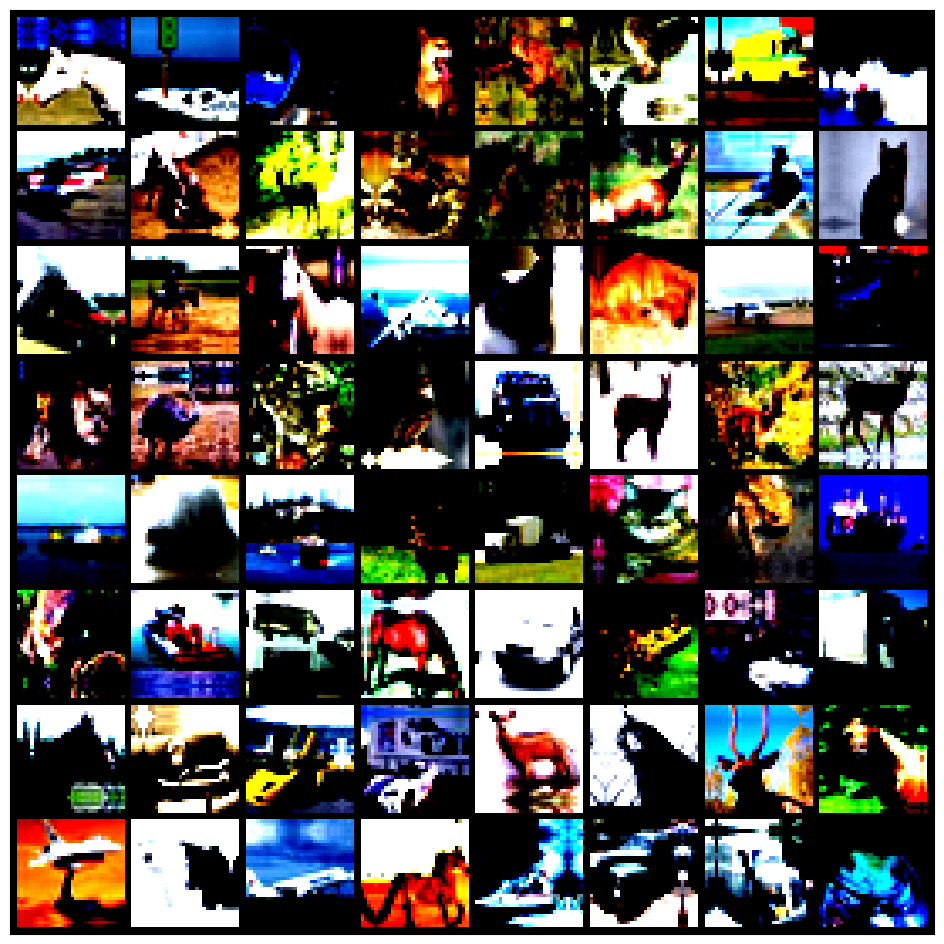

In [11]:
show_batch(train_dl)

The colors seem out of place because of the normalization. Note that normalization is also applied during inference. If you look closely, you can see the cropping and reflection padding in some of the images. Horizontal flip is a bit difficult to detect from visual inspection.

## Using a GPU

To seamlessly use a GPU, if one is available, we define a couple of helper functions (`get_default_device` & `to_device`) and a helper class `DeviceDataLoader` to move our model & data to the GPU as required. These are described in more detail in a [previous tutorial](https://jovian.ml/aakashns/04-feedforward-nn#C21).

In [12]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

Based on where you're running this notebook, your default device could be a CPU (`torch.device('cpu')`) or a GPU (`torch.device('cuda')`)

In [13]:
device = get_default_device()
device

device(type='cuda')

### CIFAR-10 nn model kan/linear

In [14]:
# Define accuracy calculation
def accuracy(outputs, labels):
    """Calculate accuracy"""
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [27]:
# Define the ResNet101 model
class ResNet101(nn.Module):
    def __init__(self, num_classes, add_kan: bool = False):
        super(ResNet101, self).__init__()
        self.model = models.resnet101(pretrained=True)  # Load pretrained weights
        if add_kan:
            self.name = 'kan'
            self.model.fc = KANLayer(self.model.fc.in_features, num_classes)  # Modify the final layer
        else:
            self.name = 'linear'
            self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)  # Modify the final layer

    def forward(self, x):
        return self.model(x)

    def validation_step(self, batch):
        """Validation step"""
        images, labels = batch[0].to(device), batch[1].to(device)
        outputs = self.forward(images)  # Generate predictions
        loss = nn.CrossEntropyLoss()(outputs, labels)  # Calculate loss
        acc = accuracy(outputs, labels)  # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        """Called at the end of the validation epoch"""
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()  # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()  # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

We can now wrap our training and validation data loaders using `DeviceDataLoader` for automatically transferring batches of data to the GPU (if available).

In [ ]:
# Full context with previous definitions...

# Function to get the default device
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

# Function to move data to the chosen device
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

# Class for loading data to device
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

# Function to evaluate model performance
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    metrics = model.validation_epoch_end(outputs)
    return metrics['val_loss'], metrics['val_acc']

# Function to get the current learning rate
def get_lr(optimizer):
    """Get the current learning rate"""
    for param_group in optimizer.param_groups:
        return param_group['lr']

# Function for training the model
def fit_model(epochs, max_lr, model, train_loader, val_loader, 
                  grad_clip=None, weight_decay=1e-4, opt_func=torch.optim.Adam) -> dict:
    """Train the model using the one-cycle learning rate policy"""
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)  # Adam optimizer
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    best_val_accuracy = 0.
    result = {
        'loss_val': [],
        'loss_train': [],
        'acc_val': [],
        'acc_train': [],
    }

    for epoch in tqdm(range(epochs), desc=f'PROCCESSING {model.name}'):
        model.train()  # Set model to training mode
        running_losses = []
        running_acc = []
        
        for batch in train_loader:
            images, labels = batch[0].to(device), batch[1].to(device)
            optimizer.zero_grad()  # Zero the gradients
            outputs = model(images)  # Forward pass
            loss = nn.CrossEntropyLoss()(outputs, labels)  # Compute loss
            loss.backward()  # Backward pass
            
            if grad_clip:  # Gradient clipping
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            # Calculate accuracy for this batch
            _, preds = torch.max(outputs, dim=1)
            correct = torch.sum(preds == labels).item()
            acc = correct / len(labels)
                
            optimizer.step()  # Update weights
            scheduler.step()  # Step the scheduler
            
            running_losses.append(loss.item())
            running_acc.append(acc)
        
        result['loss_train'].append(sum(running_losses) / len(running_losses))
        result['acc_train'].append(sum(running_acc) / len(running_acc))
        
        val_loss, val_accuracy = evaluate(model, val_loader)  # Validation step
        result['loss_val'].append(val_accuracy)

        # save model
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), f'best_{model.name}_model.pth')

        print(f"Epoch [{epoch + 1}/{epochs}], Train Loss: {sum(running_losses) / len(running_losses):.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
        result['model'] = model
    return result



### Run model learning and compare KAN outputs and Linear outlut

In [34]:
# Define the number of classes according to your dataset
num_classes = 10  # Adjust according to your dataset

# Load your data
# Assuming train_dl and valid_dl are already defined and are instances of DataLoader
# train_dl = DeviceDataLoader(train_ds, device)
# valid_dl = DeviceDataLoader(valid_ds, device)

# Set device
device = get_default_device()

model_list = [
    ResNet101(num_classes=num_classes, add_kan=False).to(device),
    ResNet101(num_classes=num_classes, add_kan=True).to(device),
]

# Set parameters for training
epochs = 2
max_lr = 0.01
grad_clip = 0.1


# Train the model
result_list = [
    fit_model(epochs, max_lr, model, train_dl, valid_dl, 
                         grad_clip=grad_clip)
    for model in model_list
]

color_list = [
    'royalblue',
    'crimson',
]



# SNS CODE

# Set Seaborn style
sns.set_theme(style="whitegrid", palette="pastel")

# Create figure
plt.figure(figsize=(12, 7))

# Plot training and validation losses for Linear and KAN
for result, color in zip(result_list, color_list):
    sns.lineplot(data=result['loss_train'], label='Linear (Train)', 
                marker='o', linestyle='-', color=color, linewidth=2)
    sns.lineplot(data=result['loss_val'], label='Linear (Val)', 
                marker='s', linestyle='--', color=color, linewidth=2)

# Customize the plot
plt.title('Training & Validation Loss: Linear vs KAN', fontsize=14, pad=20)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Improve legend and grid
plt.legend(title='Model (Type)', title_fontsize=12, fontsize=11, 
           framealpha=1, shadow=True)
plt.grid(True, linestyle='--', alpha=0.6)

# Optional: Add a light background for the curves
plt.gca().set_facecolor('#f9f9f9')

# Show plot
plt.tight_layout()
plt.show()


/home/bunkir2004/Desktop/KAN/repositories/torch-conv-kan/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/bunkir2004/Desktop/KAN/repositories/torch-conv-kan/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
PROCCESSING linear:  50%|█████     | 1/2 [00:50<00:50, 50.84s/it]

Epoch [1/2], Train Loss: 1.7545, Val Loss: 8.5021, Val Accuracy: 0.2387


PROCCESSING linear: 100%|██████████| 2/2 [01:46<00:00, 53.14s/it]


Epoch [2/2], Train Loss: 1.6950, Val Loss: 1.5552, Val Accuracy: 0.4088


PROCCESSING kan:  50%|█████     | 1/2 [00:57<00:57, 57.54s/it]

Epoch [1/2], Train Loss: 1.3904, Val Loss: 1.3975, Val Accuracy: 0.5443


PROCCESSING kan: 100%|██████████| 2/2 [01:54<00:00, 57.30s/it]

Epoch [2/2], Train Loss: 0.8693, Val Loss: 0.6952, Val Accuracy: 0.7748


NameError: name 'sns' is not defined